In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25861 sha256=cf1082f68f8f8b982e8bbc73a765875f6663abe2b23a3e435138552fe22d6e9a
  Stored in directory: /data/home/abhishekck/.cache/pip/wheels/4b/a5/2d/4a070a801d3a3d93f033d3ee9728f470f514826e89952df3ea
Successfully built imutils


***In this project we make blood disease classification using tensorflow and keras ***

there are four blood disease :
1.  MONOCYTE
2.  NEUTROPHIL
3.  LYMPHOCYTE
4.  EOSINOPHIL

there are two folder of the data :
1. train
2. test

,and there are four folder in each folder (train,test,predict),for every blood disease

**Import the tool we need it**

In [9]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scipy
# !pip install skikit-learn
!pip3 install -U scikit-learn
# !pip install tensorflow
# !pip install os-sys
# !python -m pip install -U scikit-image
# !pip install glob2
# !pip install opencv-python

     |████████████████████████████████| 30.8 MB 246 kB/s eta 0:00:01
     |████████████████████████████████| 297 kB 42.7 MB/s eta 0:00:01


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance as dist
import os
import cv2
import glob as gb
from skimage.filters import gaussian
from skimage.morphology import dilation,erosion
from skimage.feature import canny
from skimage.measure import find_contours
import imutils
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


**Let's go to create function to select the edges of the images**

In [11]:
def findedges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged
    

**Let's go to create function to get the contours of the images**

In [12]:
def getimageconturs(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours
    

**Let's go to create function to get the boxes of the images**

In [13]:
def getboxes(contours,orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

In [14]:
image_size=(120,120)
code={"EOSINOPHIL":0,"LYMPHOCYTE":1,"MONOCYTE":2,"NEUTROPHIL":3}
def getcode(n):
    if type(n)==str:
        for x,y in code.items():
            if n==x:
                return y 
    else:
        for x,y in code.items():
            if n==y:
                return x

**Here we create a function to load data and do collection of operations**

In [17]:
def loaddata():
    datasets=["Data/blood_cell_data/dataset2-master/dataset2-master/images/TRAIN/",
          "Data/blood_cell_data/dataset2-master/dataset2-master/images/TEST/",]



    
    images=[]
    labels=[]
    count=0
    for dataset in datasets:
        for folder in os.listdir(dataset):
            files=gb.glob(pathname=str(dataset+folder+"/*.jpeg"))
            label=getcode(folder)
            for file in files:
                image = cv2.imread(file)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # add padding to the image to better detect cell at the edge
                image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
                
                #thresholding the image to get the target cell
                image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
                
                # openning errosion then dilation
                kernel = np.ones((3, 3), np.uint8)
                kernel1 = np.ones((5, 5), np.uint8)
                img_erosion = cv2.erode(image1, kernel, iterations=2)
                image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
                
                #detecting the blood cell
                edgedImage = findedges(image1)
                edgedContours = getimageconturs(edgedImage)
                edgedBoxes =  getboxes(edgedContours, image.copy())
                if len(edgedBoxes)==0:
                    count +=1
                    continue
                # get the large box and get its cordinate
                last = edgedBoxes[-1]
                max_x = int(max(last[:,0]))
                min_x = int( min(last[:,0]))
                max_y = int(max(last[:,1]))
                min_y = int(min(last[:,1]))
                
                # draw the contour and fill it 
                mask = np.zeros_like(image)
                cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                
                # any pixel but the pixels inside the contour is zero
                image[mask==0] = 0
                
                # extract th blood cell
                image = image[min_y:max_y, min_x:max_x]

                if (np.size(image)==0):
                    count +=1
                    continue
                # resize th image
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images,labels
        

In [18]:
images,labels=loaddata()

In [19]:
images,labels=shuffle(images,labels,random_state=10)

In [20]:
images=images/255
train_image,test_image,train_label,test_label=train_test_split(images,labels,test_size=.2)
test_image,val_image,test_label,val_label=train_test_split(test_image,test_label,test_size=.5)


In [21]:
def displayrandomimage(image,label,typeofimage):
    plt.figure(figsize=(15,15))
    plt.suptitle("some random image of "+typeofimage,fontsize=17)
    for n,i in  enumerate(list(np.random.randint(0,len(image),36))):
        plt.subplot(6,6,n+1)
        plt.imshow(image[i])
        plt.axis("off")
        plt.title(getcode(label[i]))

***Here we call displayrandomimage function to display some image of train image ***

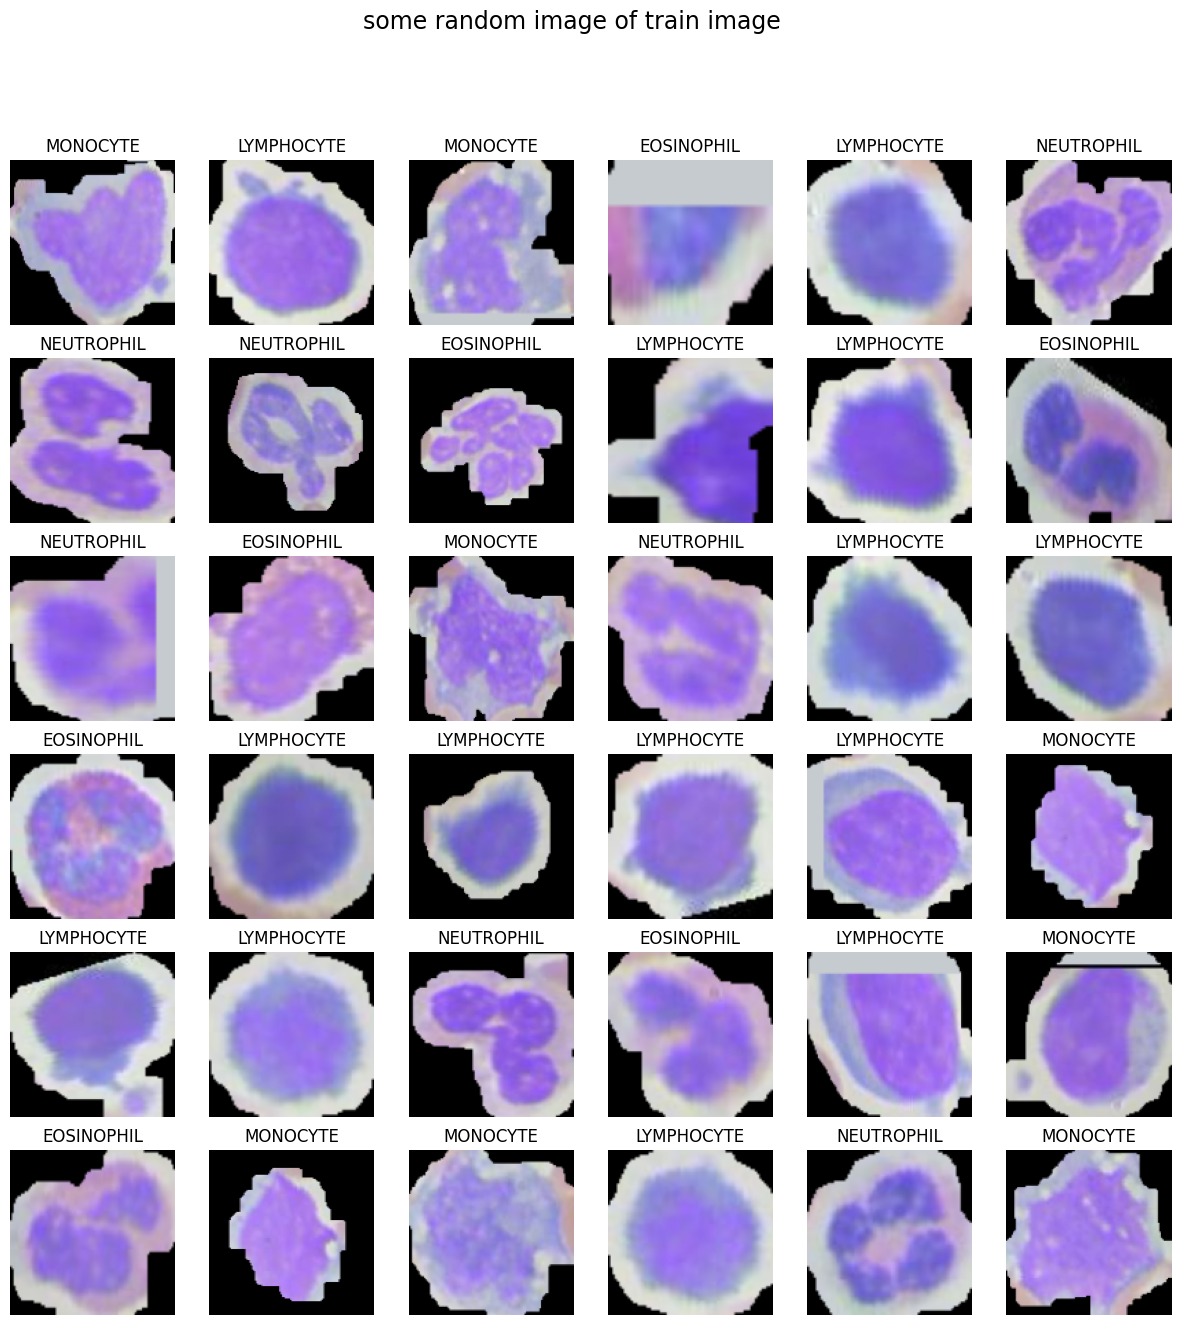

In [22]:
displayrandomimage(train_image,train_label,"train image")

***Here we call displayrandomimage function to display some image of test image ***

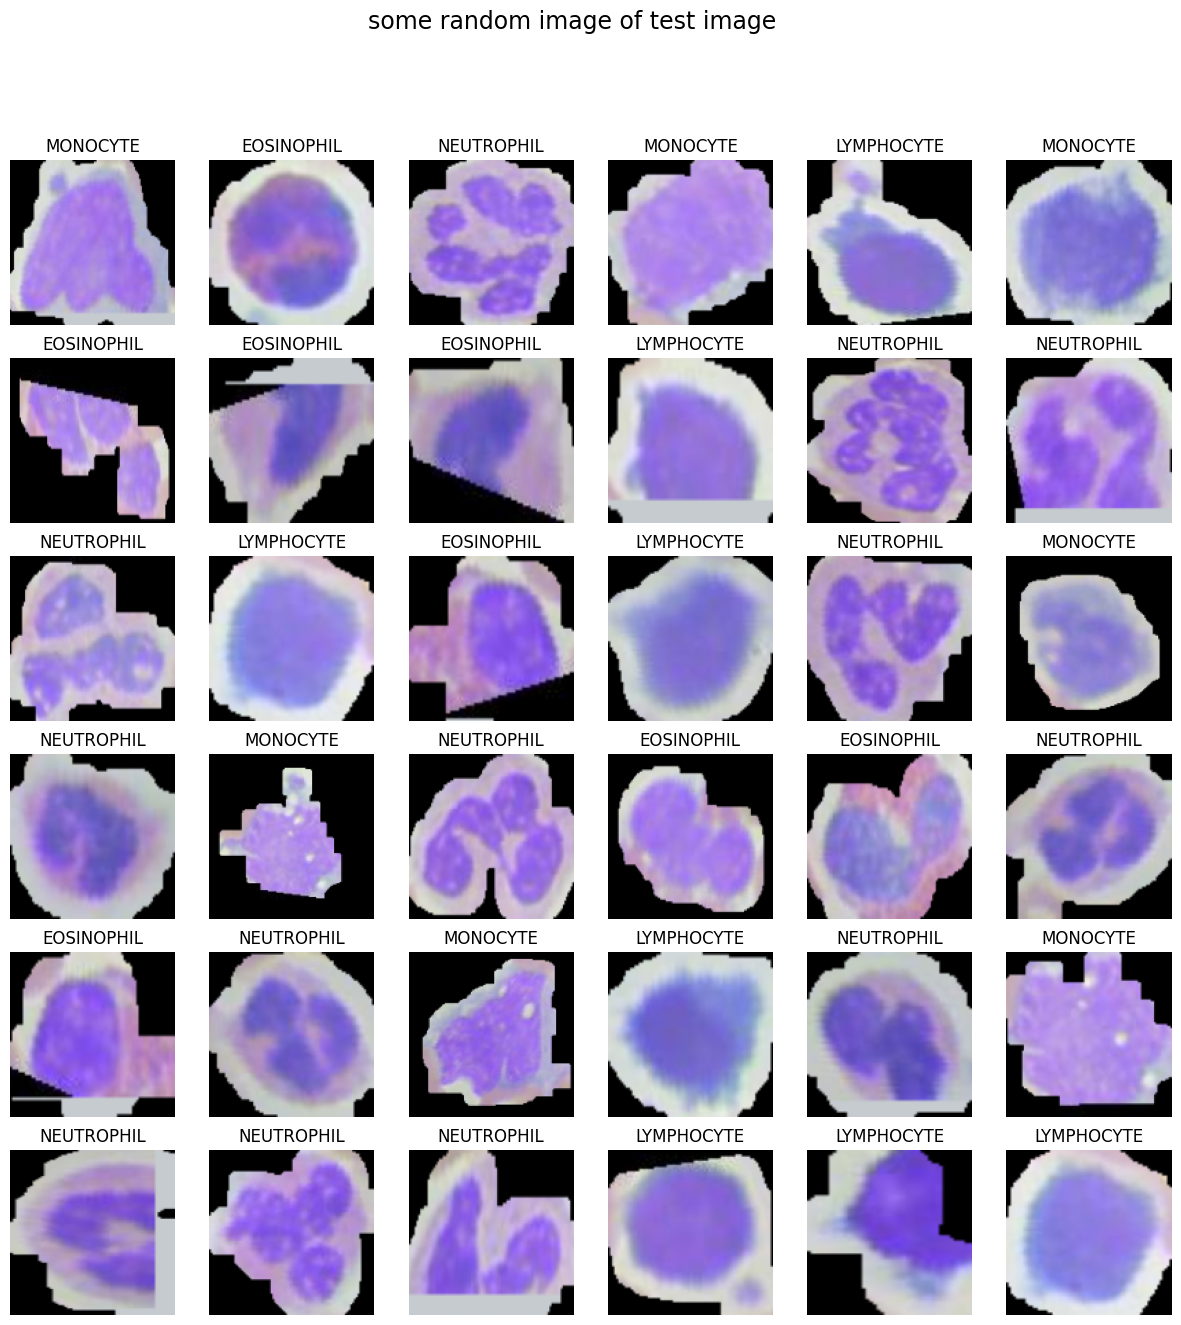

In [23]:
displayrandomimage(test_image,test_label,"test image")

****Here we call displayrandomimage function to display some image of val image ****

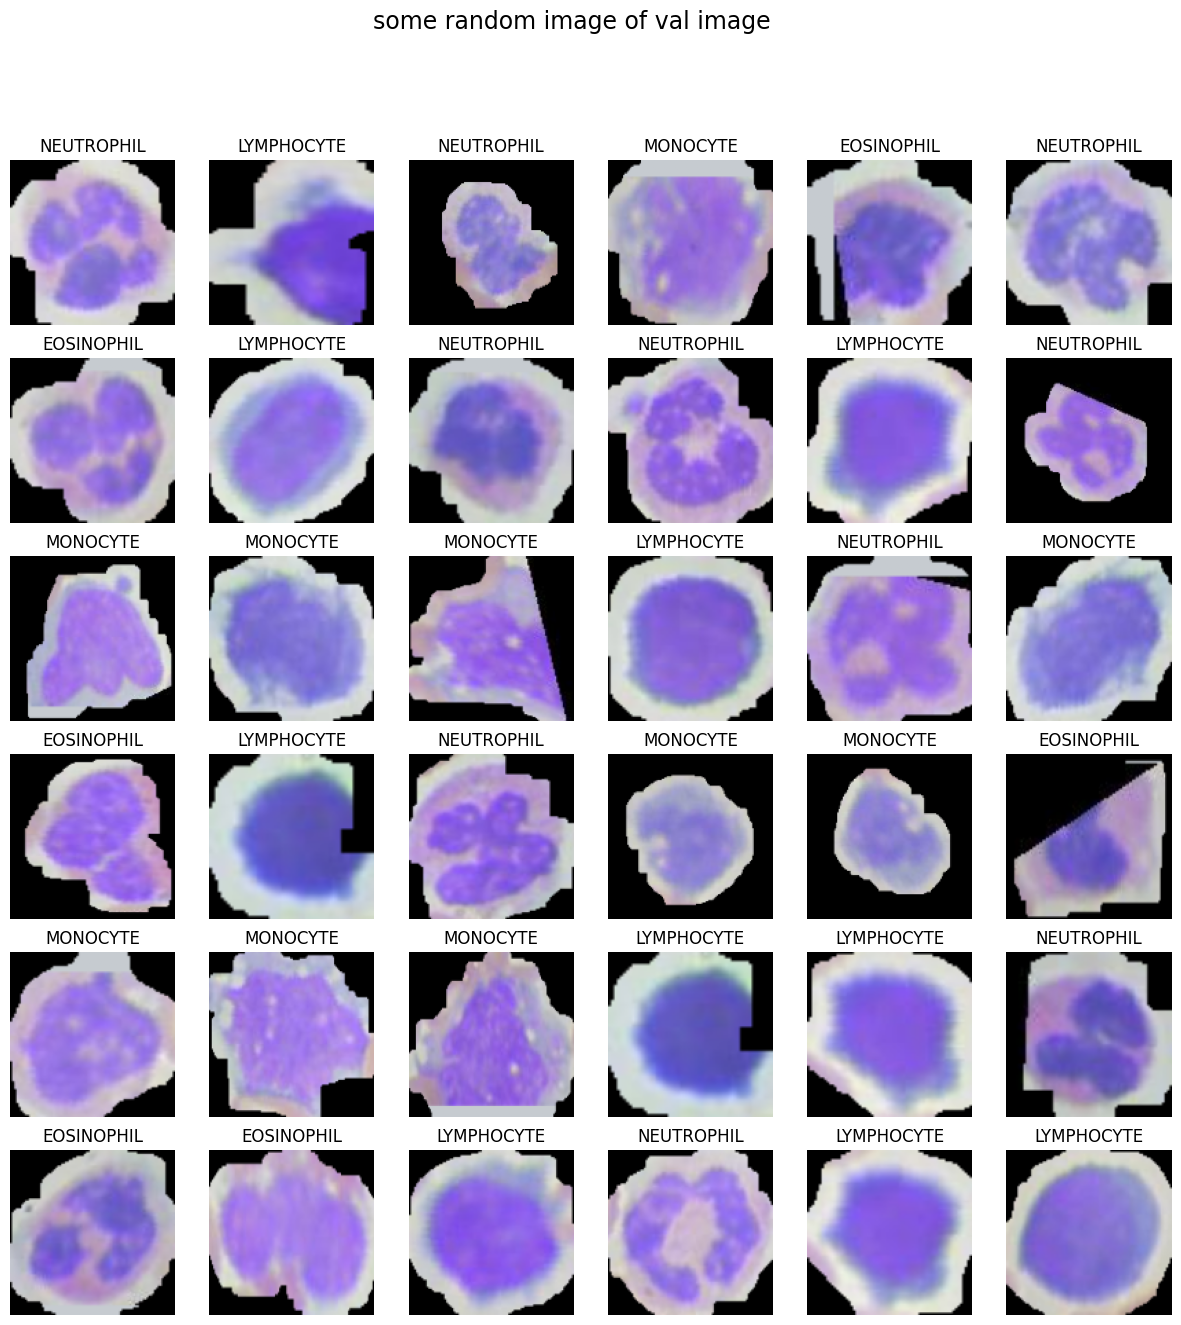

In [24]:
displayrandomimage(val_image,val_label,"val image")

**Now let's go to buil our model**

In [25]:
model=keras.models.Sequential([
    keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(120,120,3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(.25),
    keras.layers.Conv2D(128,(3,3),activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(.25),
    keras.layers.Conv2D(256,(3,3),activation="relu"),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Dropout(.25),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    #keras.layers.Dense(2048,activation='relu'),
    keras.layers.Dropout(.25),
    keras.layers.Dense(4,activation='softmax')
    
    
    
])

2022-11-30 15:45:04.593014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 15:45:12.838195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28216 MB memory:  -> device: 0, name: NVIDIA Tesla V100-SXM2-32GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-30 15:45:12.841649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30971 MB memory:  -> device: 1, name: NVIDIA Tesla V100-SXM2-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2022-11-30 15:45:12.845326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0

In [26]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['accuracy'])

**Let's go to show the summry of our model**

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 59, 59, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 128)       0

In [28]:
epochs=30

**Woundderfull**

**Let's go to train our model**



In [31]:
history=model.fit(train_image,
                  train_label,
                  epochs=epochs,
                  batch_size=32,
                  validation_data=(val_image,val_label))

Epoch 1/30


2022-11-30 15:47:50.876212: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-11-30 15:47:51.883940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8303
2022-11-30 15:47:53.057382: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe140011bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-30 15:47:53.057434: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-11-30 15:47:53.057444: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-11-30 15:47:53.057451: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2)

304/304 [==============================] - 12s 24ms/step - loss: 1.2977 - accuracy: 0.4716 - val_loss: 0.7661 - val_accuracy: 0.6527
Epoch 2/30
304/304 [==============================] - 7s 22ms/step - loss: 0.6841 - accuracy: 0.7092 - val_loss: 0.6027 - val_accuracy: 0.7457
Epoch 3/30
304/304 [==============================] - 6s 21ms/step - loss: 0.4203 - accuracy: 0.8325 - val_loss: 0.2419 - val_accuracy: 0.8979
Epoch 4/30
304/304 [==============================] - 6s 21ms/step - loss: 0.2999 - accuracy: 0.8791 - val_loss: 0.1924 - val_accuracy: 0.9292
Epoch 5/30
304/304 [==============================] - 6s 21ms/step - loss: 0.1986 - accuracy: 0.9236 - val_loss: 0.2073 - val_accuracy: 0.9235
Epoch 6/30
304/304 [==============================] - 6s 21ms/step - loss: 0.1596 - accuracy: 0.9374 - val_loss: 0.1502 - val_accuracy: 0.9498
Epoch 7/30
304/304 [==============================] - 6s 21ms/step - loss: 0.1313 - accuracy: 0.9511 - val_loss: 0.1452 - val_accuracy: 0.9556
Epoch 8/3

In [32]:
loss,acuracy=model.evaluate(test_image,test_label)
print("the accuracy of test image is : ",acuracy)

38/38 [==============================] - 0s 7ms/step - loss: 0.3212 - accuracy: 0.9481
the accuracy of test image is :  0.9481481313705444


In [33]:
def plot_acc_and_loss_of_train_and_val(history):
    #plt.figure(figsize=(15,15))
    #plt.suptitle("acc,loss of train VS acc,loss of val")
    epochs=[i for i in range(30)]
    train_acc=history.history['accuracy']
    train_loss=history.history['loss']
    val_acc=history.history['val_accuracy']
    val_loss=history.history['val_loss']
    fig , ax=plt.subplots(1,2)
    fig.set_size_inches(20,10)
    ax[0].plot(epochs,train_acc,'go-',label='training accuracy')
    ax[0].plot(epochs,val_acc,'ro-',label='validation accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epochs,train_loss,'g-o',label='training loss')
    ax[1].plot(epochs,val_loss,'r-o',label='validation loss')
    ax[1].set_title('Training & Validation loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")

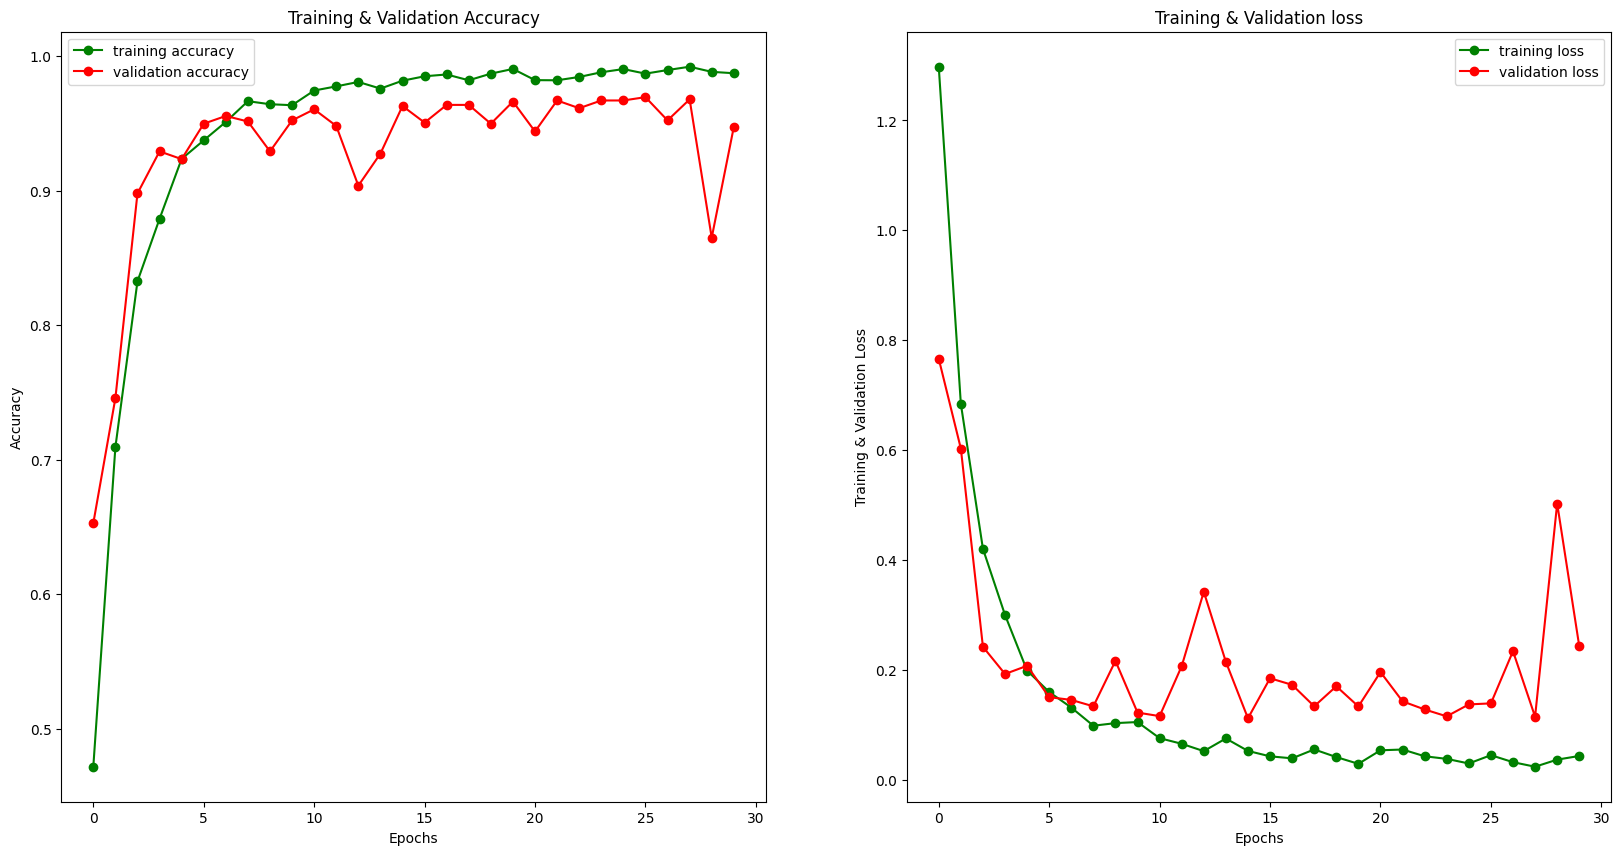

In [34]:
plot_acc_and_loss_of_train_and_val(history)

In [35]:
model.save("CNN BLOOD DISEASE")

INFO:tensorflow:Assets written to: CNN BLOOD DISEASE/assets


INFO:tensorflow:Assets written to: CNN BLOOD DISEASE/assets
